### example

In [159]:
print(__doc__)

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


In [160]:
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer

noise_level = 0.1

In [161]:
def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

def objective_wo_noise(x, noise_level=0):
    return objective(x, noise_level=0)

In [162]:
opt = Optimizer([(-2.0, 2.0)], "GP", acq_func="PI",acq_optimizer="sampling",initial_point_generator="lhs")

# To obtain a suggestion for the point at which to evaluate the objective
# you call the ask() method of opt:

next_x = opt.ask()
print(next_x)

[1.9751879462233664]


In [163]:
f_val = objective(next_x)
opt.tell(next_x, f_val);

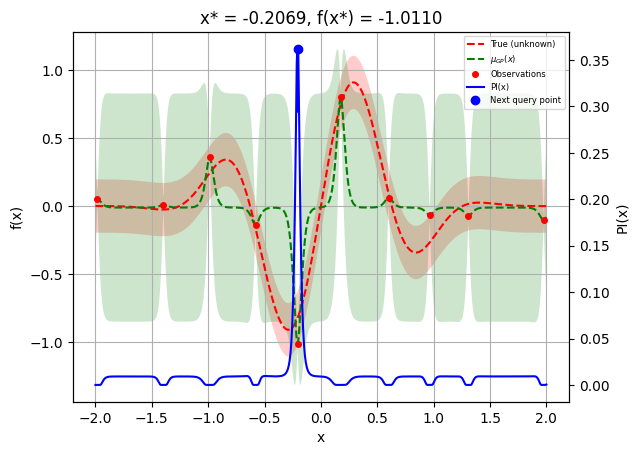

In [172]:
# for i in range(9):
#     print('='*50)
#     next_x = opt.ask()
#     f_val = objective(next_x)
#     res = opt.tell(next_x, f_val)
#     plot_gaussian_process(res, objective=objective_wo_noise,
#                           noise_level=noise_level,
#                           show_next_point=False,
#                           show_acq_func=True)
#     print(res)

next_x = opt.ask()
f_val = objective(next_x)
res = opt.tell(next_x, f_val)
try:
    plot_gaussian_process(
        res, 
        objective=objective_wo_noise,
        noise_level=noise_level,
        show_next_point=True,
        show_acq_func=True
    )
except:
    pass

In [120]:
# for i in range(10):
#     next_x = opt.ask()
#     f_val = objective(next_x)
#     res = opt.tell(next_x, f_val)

# _ = plot_gaussian_process(res, objective=objective_wo_noise,
#                           noise_level=noise_level,
#                           show_next_point=True,
#                           show_acq_func=True)
# plt.show()

In [121]:
# res

In [122]:
experiment_outputs = np.array([[1.9751879462233664], [0.9644139281416222], [-1.3969037306142713], [0.601280292322484], [-1.9826594114927345], [0.17502792585950866], [-0.9867536065564471], [1.3087623601273477], [-0.20685421698321949], [-0.5799449251656619], [-0.18874461304192547], [-0.17237740912645094], [-0.2722611128686978], [-0.32915313554970993], [-0.32043158856047427], [-0.3368407898817609], [1.6645068837088108], [-0.3069701049406519], [-1.699687398111938], [-0.3599278426120822]])
opt.base_estimator_.kernel(experiment_outputs);

In [39]:
# Use the GP model's predict method to get the mean predictions
# You can also get the standard deviations by setting return_std=True
means, std_devs = opt.base_estimator_.predict(experiment_outputs, return_std=True)

print("Mean predictions for each point:")
print(means)

print("\nStandard deviations for each point (uncertainties):")
print(std_devs)


Mean predictions for each point:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Standard deviations for each point (uncertainties):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Fitting a prior with MLE

In [158]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from skopt import gp_minimize

In [ ]:
from sklearn.linear_model import LinearRegression

past_price = np.array([0.3288, 0.2796, 0.24, 0.3288, 0.2796, 0.18, 0.24])
past_result = np.array([0.0161, 0.0146, 0.0145, 0.0244, 0.059, 0.0221, 0.0287])

# Fit a linear regression model as a mean function
mean_model = LinearRegression()
mean_model.fit(past_price, past_result)
# Predict the mean at any price
mean_prior = mean_model.predict(past_result)


kernel = C(1.0, (1e-4, 1e1)) * RBF(10, (1e-2, 1e2))
# Gaussian Process with the custom kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
# Fit the GP to the historical data (this optimizes the hyperparameters via MLE)
gp.fit(past_price, past_price - mean_prior)  # Subtract mean prior from targets

In [ ]:
from skopt import gp_minimize

# Define the objective function
def objective(price):
    # Incorporate the mean prior and GP predictions
    mean_price = mean_model.predict([[price]])[0]
    gp_mean, gp_std = gp.predict([[price]], return_std=True)
    return -(mean_price + gp_mean)  # Maximize profits (negate for minimization in skopt)

# Run Bayesian optimization
res = gp_minimize(objective,  # the objective function
                  [(0, 60)],  # bounds for the price range
                  n_calls=20,  # number of calls to the objective function
                  random_state=0)